In [ ]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#Epipolar Geometry


## Overview

Implements an algorithm for automatically estimating homography with RANSAC.

The outline of the normalized 8-point algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/8pointalgo.jpg" width="700"/>



In [ ]:
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_

!unzip "/content/Part1_data.zip" -d "/content/"
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 28.2MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.axis('off')
    plt.show()


### Code

In [ ]:
def normalize(x, y):
  """
  Function: find the transformation T to make coordinates zero mean and the variance as sqrt(2)
  Input: x, y - coordinates
  Output: normalized coordinates, transformation T
  """
  x = np.array(x)
  y = np.array(y)

  mean_x_pts = np.mean(x)
  mean_y_pts = np.mean(y)

  x_zero_mean_val = x - mean_x_pts
  y_zero_mean_val = y - mean_y_pts

  average_distance = np.mean(np.sqrt(x_zero_mean_val ** 2 + y_zero_mean_val ** 2))

  x_new = x_zero_mean_val * (np.sqrt(2) / average_distance)
  y_new = y_zero_mean_val * (np.sqrt(2) / average_distance)

  T = np.array([[(np.sqrt(2) / average_distance), 0, -(np.sqrt(2) / average_distance)*mean_x_pts],[0, (np.sqrt(2) / average_distance), -(np.sqrt(2) / average_distance)*mean_y_pts],[0, 0, 1]])

  normalized = np.column_stack((x_new, y_new))

  return normalized, T


def ransacF(x1, y1, x2, y2, num_iterations=1000, threshold=0.01):
  """
  Find normalization matrix
  Transform point set 1 and 2
  RANSAC based 8-point algorithm
  Input:
     x1, y1, x2, y2 - coordinates
     num_iterations - how many iterations
     threshold - threshold for inlier check
  Output:
     Best fundamental matrix
     corresponding inlier indices
  """
  inliers_arr = []
  finalF = None

  points1, T1 = normalize(x1, y1)
  points2, T2 = normalize(x2, y2)

  for i in range(num_iterations):
    rand_points = np.random.choice(len(x1), 8, replace=False)
    x1_new = x1[rand_points]
    y1_new = y1[rand_points]
    x2_new = x2[rand_points]
    y2_new = y2[rand_points]

    F = computeF(x1_new, y1_new, x2_new, y2_new)

    F = T2.T @ F @ T1

    inlier_valid = getInliers(x1, y1, x2, y2, F, threshold)

    if len(inlier_valid) > len(inliers_arr):
        inliers_arr = inlier_valid
        finalF = F

  return finalF, inliers_arr

def computeF(x1, y1, x2, y2):
  """
  Function: compute fundamental matrix from corresponding points
  Input:
     x1, y1, x2, y2 - coordinates
  Output:
     fundamental matrix, 3x3
  """

  A = np.zeros((len(x1), 9))
  x1_new = x1.flatten()
  y1_new = y1.flatten()
  y2_new = y2.flatten()
  x2_new = x2.flatten()

  for i in range(len(x1)):
      A[i] = [x2_new[i]*x1_new[i], x2_new[i]*y1_new[i], x2_new[i], y2_new[i]*x1_new[i], y2_new[i]*y1_new[i], y2_new[i], x1_new[i], y1_new[i], 1]

  p1, p2, p3 = np.linalg.svd(A)
  F = p3[-1].reshape(3, 3)

  p1, p2, p3 = np.linalg.svd(F)
  p2[-1] = 0
  F = np.dot(p1, np.dot(np.diag(p2), p3))
  return F

def getInliers(x1, y1, x2, y2, F, thresh):
  """
   Function: implement the criteria checking inliers.
   Input:
     x1, y1, x2, y2 - coordinates
     F - estimated fundamental matrix, 3x3
     thresh - threshold for passing the error
   Output:
     inlier indices
  """

  one_M = np.ones(x1.shape[0])
  points_1 = np.vstack((x1, y1, one_M)).T
  points_2 = np.vstack((x2, y2, one_M)).T

  lines_corr = np.dot(F, points_1.T).T

  num = np.abs(np.sum(lines_corr * points_2, axis=1))
  denom = np.sqrt(lines_corr[:, 0] **2 + lines_corr[:, 1] **2)
  distance = num / denom
  inlier_valid = np.where(distance <= thresh)[0]

  return inlier_valid


In [ ]:
from sklearn.metrics import mean_squared_error

p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of image1 in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of image2 in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

px1, py1 = p1[:, :1], p1[:, 1:2]
px2, py2 = p2[:, :1], p2[:, 1:2]

# Normalize points
norm_p1, T1 = normalize(px1, py1)
norm_x1, norm_y1 = norm_p1[:, :1], norm_p1[:, 1:2]
norm_p2, T2 = normalize(px2, py2)
norm_x2, norm_y2 = norm_p2[:, :1], norm_p2[:, 1:2]

# Compute fundamental matrix with computeF()
F_ours = computeF(norm_x1, norm_y1, norm_x2, norm_y2)
F_ours = np.matmul(np.matmul(np.transpose(T2),F_ours), T1)
F_ours = F_ours / F_ours[2, 2]
print("Our F: ", F_ours)
# Compute fundamental matrix with cv2.findFundamentalMat()
F_cv2, _ = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)
print("CV2 F: ", F_cv2)

# Display difference.
mse_err = mean_squared_error(F_ours, F_cv2)
print(f'\n MSE of fundamental matrixes = {mse_err }')

if mse_err < 1e-12:
  print("Sanity check passed!")
else:
  print("Sanify check failed!")

Our F:  [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]
CV2 F:  [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]

 MSE of fundamental matrixes = 9.266490671470514e-30
Sanity check passed!


In [ ]:
points_1, T1 = normalize(x1, y1)
points_2, T2 = normalize(x2, y2)

iterations = int(np.log(1 - 0.99) / np.log(1 - (1 - 0.5)**8))

F, inliers = ransacF(points_1[:, 0], points_1[:, 1], points_2[:, 0], points_2[:, 1], iterations)

F = T2.T @ F @ T1

F /= F[-1, -1]

print("Fundamental Matrix F:", F)


Fundamental Matrix F: [[-1.73802575e-06  2.17906607e-04 -3.83194683e-02]
 [-2.30718747e-04 -9.51535535e-06 -7.06107098e-02]
 [ 4.28634434e-02  7.16719636e-02  1.00000000e+00]]


The test used for deciding inliers vs outliers first uses the fundamental matrix to find the corresponding epipolar line in the second image for each point in the first image. After this, the distance between each point in the second image and its corresponding epipolar line is calculated. the formula for this distance can be described as d = |ax + by + c| / sqrt(a^2 + b^2), where (x,y) represents the point and (a,b,c) represents the corresponding epipolar line. Finally, this distance value is compared to a pre determined threshold value to identify what the inliers and outliers are. All distances that are less than or equal to the specific threshold are considered inlier points, while distances that do not meet this requirment are outliers.  


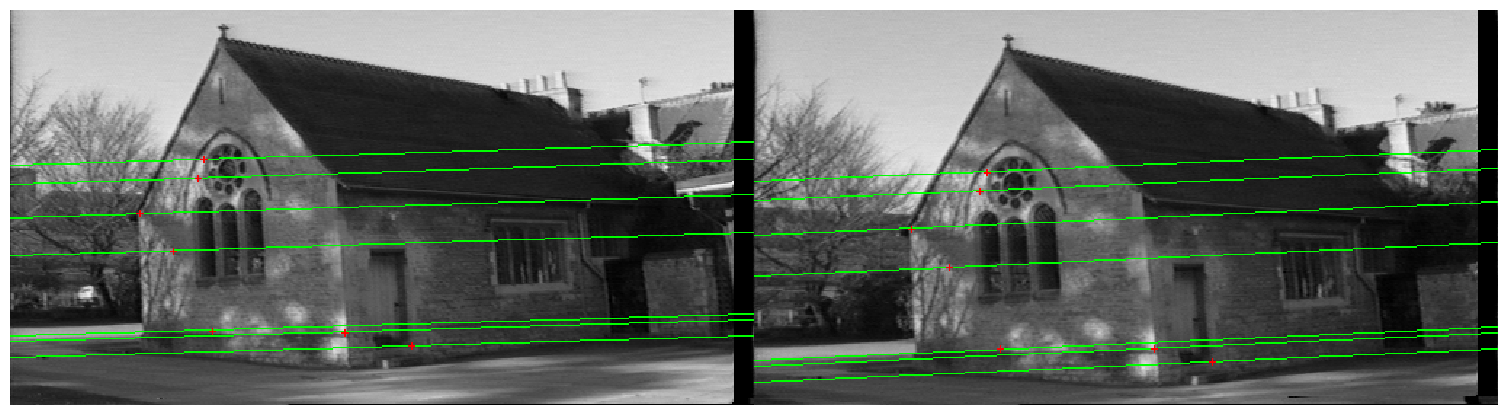

In [ ]:
image1 = cv2.imread('Part1_data/chapel00.png')
image2 = cv2.imread('Part1_data/chapel01.png')

iterations = np.log(1 - 0.99) / np.log(1 - (1 - 0.5)**8)

iterations = int(np.ceil(iterations))

points1, t1 = normalize(x1, y1)
points2, t2 = normalize(x2, y2)

finalF, inliers_valid = ransacF(points1[:, 0], points1[:, 1],points2[:, 0], points2[:, 1], iterations, 0.01)

denormalized = t2.T @ finalF @ t1

normalized = denormalized / denormalized[-1, -1]

rand_points = np.random.choice(len(inliers_valid), 7, replace=False)

norm_points1 = points1[inliers_valid][rand_points]
norm_points2 = points2[inliers_valid][rand_points]

pts = np.hstack([norm_points1, np.ones((norm_points1.shape[0], 1))])
pts_h = np.dot(np.linalg.inv(t1), pts.T).T
denorm_pts = pts_h[:, :2] / pts_h[:, 2, np.newaxis]
denorm_points1 = denorm_pts

pts = np.hstack([norm_points2, np.ones((norm_points2.shape[0], 1))])
pts_h = np.dot(np.linalg.inv(t2), pts.T).T
denorm_pts = pts_h[:, :2] / pts_h[:, 2, np.newaxis]
denorm_points2 = denorm_pts

lines_1 = cv2.computeCorrespondEpilines(denorm_points2.reshape(-1,1,2), 2, normalized).reshape(-1, 3)
lines_2 = cv2.computeCorrespondEpilines(denorm_points1.reshape(-1,1,2), 1, normalized).reshape(-1, 3)

def draw_helper(img1, img2, lines, pts1, pts2):
    img_copy1 = img1.copy()
    img_copy2 = img2.copy()
    rows, cols = img1.shape[:2]
    for line, pt1, pt2 in zip(lines, pts1, pts2):
        x_0, y_0 = map(int, [0, -line[2]/line[1] ])
        x_1, y_1 = map(int, [cols, -(line[2]+line[0] *cols)/line[1] ])
        img_copy1 = cv2.line(img_copy1, (x_0, y_0), (x_1, y_1), (0, 255, 0), 1)
        img_copy1 = cv2.drawMarker(img_copy1, tuple(np.int32(pt1)), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5)
        img_copy2 = cv2.drawMarker(img_copy2, tuple(np.int32(pt2)), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5)
    return img_copy1, img_copy2

image1_drawlines, _ = draw_helper(image1, image2, lines_1, denorm_points1, denorm_points2)
image3_drawlines, _ = draw_helper(image2, image1, lines_2, denorm_points2, denorm_points1)

concatenated = np.concatenate((image1_drawlines, image3_drawlines), axis=1)

show_image(concatenated, scale=4)



# Image stitching

## Overview

Implements an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm.

In [ ]:
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 27.3MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 68.0MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1],
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code

In [ ]:
def crop_dark(panorama):
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_area_contour)
    panorama = panorama[y:y+h, x:x+w]

    return panorama


def find_homography_ransac(src, dest, threshold=0.5, max_iterations=1000):
    """
    Run RANSAC to estimate H.
    Input:
    - src, dest: coordinates
    - threshold: threshold for RANSAC
    - max_iterations: number of iterations for RANSAC
    Output:
    - estimated homography H
    - inliers
    """
    inliers_arr = []
    finalH = None

    for i in range(max_iterations):
        rand_pts = np.random.choice(np.arange(src.shape[0]), 4, replace=False)
        src_final = src[rand_pts]
        dest_final = dest[rand_pts]
        H = est_homography(src_final, dest_final)

        transformed = apply_homography(H, src)

        distance_diff = np.sqrt(np.sum((transformed - dest) ** 2, axis=1))

        valid_inliers = np.where(distance_diff < threshold)[0]

        if len(valid_inliers) > len(inliers_arr):
            inliers_arr = valid_inliers
            finalH = H

    if finalH is not None:
        finalH = est_homography(src[inliers_arr], dest[inliers_arr])

    return finalH, inliers_arr

def stitch_images(img1, img2):
    """
    Stitch two images at a time.
    Inputs:
    - img1, img2 with shape [H, W, 3].
    Output:
    - stitched_image with shape [H, W, 3].
    """

    sift = cv2.SIFT_create()

    keypt1, descrip1 = sift.detectAndCompute(img1, None)
    keypt2, descrip2 = sift.detectAndCompute(img2, None)

    ind = dict(algorithm=1, trees=5)
    search = dict(checks=50)
    flannMatcher = cv2.FlannBasedMatcher(ind, search)

    matches = flannMatcher.knnMatch(descrip1, descrip2, k=2)

    filter_matches = []
    for x, y in matches:
        if x.distance < 0.75 * y.distance:
            filter_matches.append(x)

    points_1 = []
    for x in filter_matches:
      pt = keypt1[x.queryIdx].pt
      points_1.append(pt)
    points_1 = np.float32(points_1).reshape(-1, 2)

    points_2 = []
    for x in filter_matches:
      pt = keypt2[x.trainIdx].pt
      points_2.append(pt)
    points_2 = np.float32(points_2).reshape(-1, 2)


    H, _ = find_homography_ransac(points_2, points_1, 0.5, 1000)

    if H is not None:
      H_Normalized = H / H[2, 2]
      print("Homography:\n", H_Normalized)

    stitched = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    stitched[0:img1.shape[0], 0:img1.shape[1]] = img1

    stitched = crop_dark(stitched)

    return stitched



['/content/hill/1.JPG', '/content/hill/2.JPG', '/content/hill/3.JPG']
Homography:
 [[ 8.97519036e-01  1.84349818e-02  1.35869012e+02]
 [-4.86194571e-02  9.76918690e-01 -1.54639262e+01]
 [-2.80991632e-04  4.59201714e-05  1.00000000e+00]]


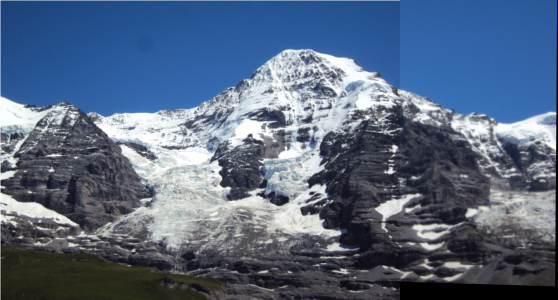

In [ ]:
#two images
import glob
case_name = "hill"
imgs_path = "/content/" + case_name
img_list = sorted(glob.glob(os.path.join(imgs_path, "*.JPG"))) + sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
print(img_list)


img1 = cv2.imread(img_list[1])
img2 = cv2.imread(img_list[2])

stitched_12 = stitch_images(img1, img2)

from google.colab.patches import cv2_imshow
cv2_imshow(stitched_12)

Homography:
 [[ 8.97599296e-01  1.85384652e-02  1.35857335e+02]
 [-4.86224586e-02  9.77051578e-01 -1.54748566e+01]
 [-2.80981953e-04  4.63031740e-05  1.00000000e+00]]


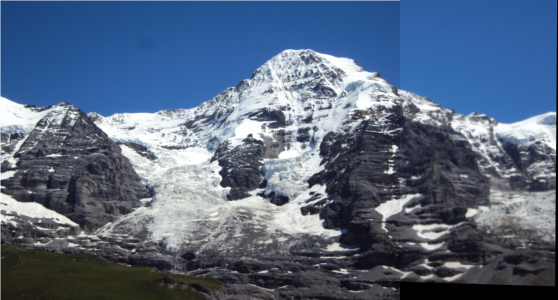

Homography:
 [[ 8.84863915e-01  5.94094405e-02  1.44525865e+02]
 [-9.12599778e-02  9.75920489e-01 -1.16985818e+01]
 [-3.16386970e-04  5.14882842e-05  1.00000000e+00]]


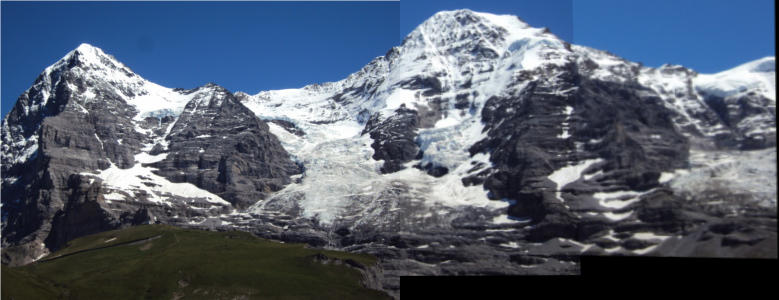

In [ ]:
#three images

img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1])
img3 = cv2.imread(img_list[2])

stitched = stitch_images(img2, img3)
cv2_imshow(stitched)

final= stitch_images(img1, stitched)

cv2_imshow(final)


['/content/tv/1.jpg', '/content/tv/2.jpg', '/content/tv/3.jpg']
Homography:
 [[ 6.22180130e-01 -3.44404352e-02  2.70961834e+02]
 [-2.32310574e-01  8.94711612e-01  2.99742025e+01]
 [-7.76575870e-04 -4.39316176e-05  1.00000000e+00]]


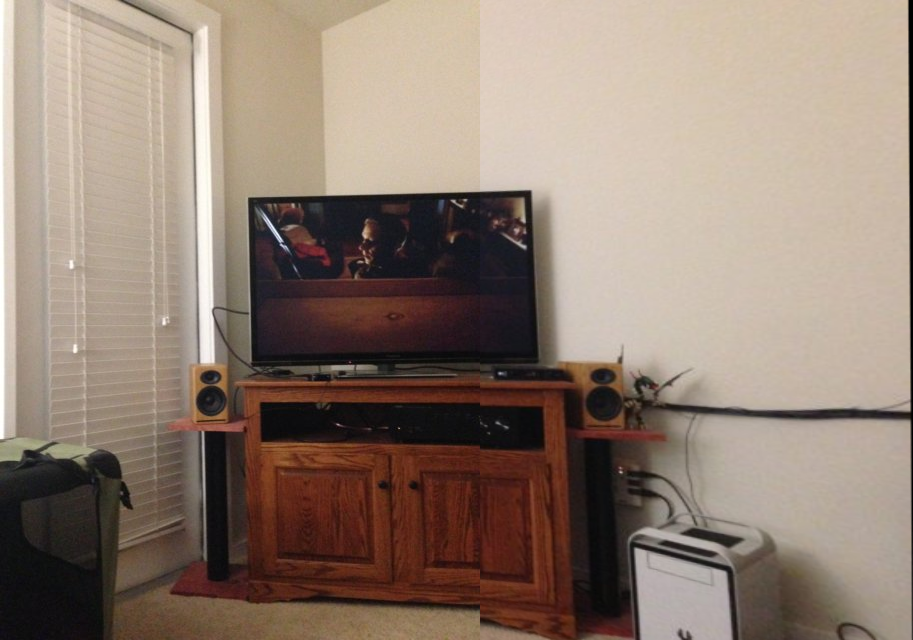

Homography:
 [[ 3.23598380e-01 -3.82165774e-02  4.79859215e+02]
 [-4.33459705e-01  9.99390797e-01  1.93597582e+00]
 [-1.41871338e-03 -2.27701344e-05  1.00000000e+00]]


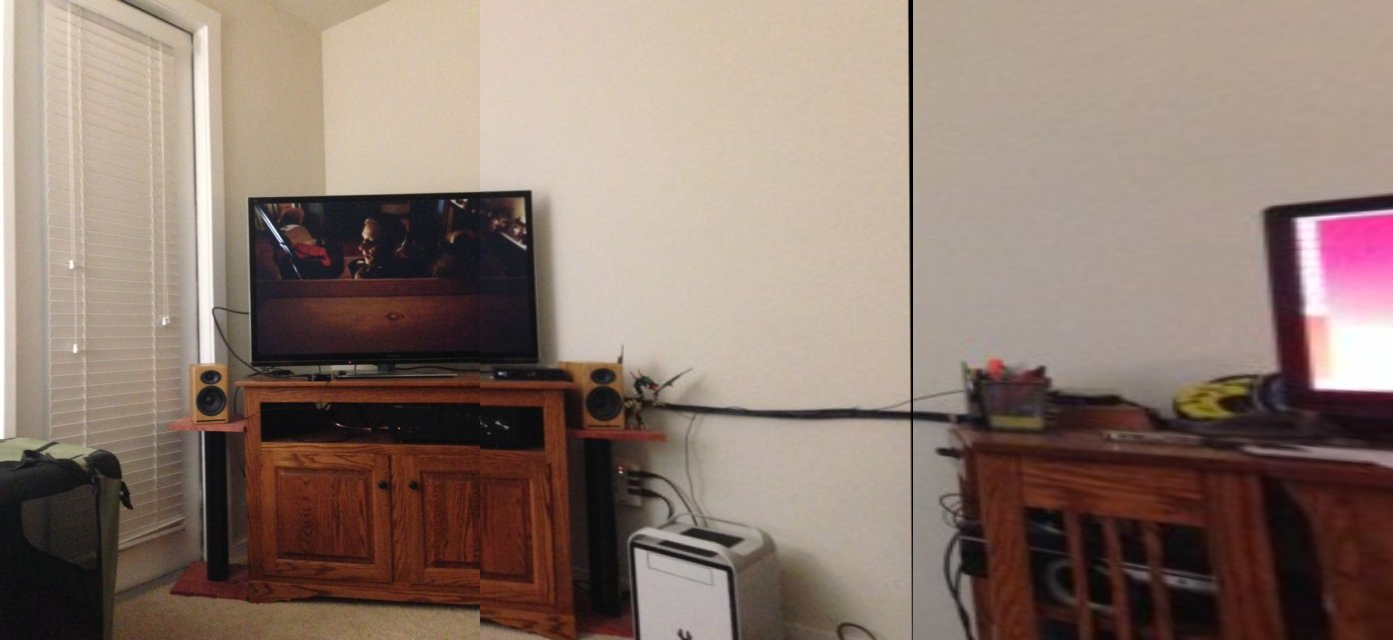

In [ ]:
case_name = "tv"
imgs_path = "/content/" + case_name
img_list = sorted(glob.glob(os.path.join(imgs_path, "*.JPG"))) + sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
print(img_list)

img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1])
img3 = cv2.imread(img_list[2])

stitched = stitch_images(img1, img2)

cv2_imshow(stitched)

final = stitch_images(stitched, img3)

cv2_imshow(final)



The RANSAC algorithm starts off by selectign random points at the start of each iterations. By selecting these random samples repeatedly, incorrect matches are not likely to influence the model. The algorithm finds the Euclidean distance between the points being transformed and the respective expected position. All the distances that are less than or equal to a certain pre determined threshold value are kept and considered inliers. The points that do not meet that requirments are removed, as they are incorrect matches.